## Demonstração - Modelar a predição de churn utilizando tecnicas de classificação (Decision Tree, KNN e Random Forest)

#### Pergunta inicial: Quais clientes provavelmente cancelarão e como podemos evitar isso proativamente?

__Passo 1:__ Importar os pacotes

In [2]:
# Pacotes do sistema
import sys
import io
from base64 import b64encode
from __future__ import division

# Pacotes para analise
import pandas as pd
import numpy as np

# Pacotes dos modelos, metricas
from sklearn import cross_validation
from patsy import dmatrices
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import confusion_matrix


# Pacotes para visualização
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.2)
from IPython.display import Image
from IPython.display import HTML,display

# Permite que os gráficos sejam apresentados no notebook
%matplotlib inline
plt.style.use('ggplot')

__Passo 2:__ Importar os dados, carregá-lo em um dataframe pandas

Ref.:https://github.com/nmingmei/Telecom_Churn_Rate

 O conjunto de dados consiste de informações sobre o consumo de chamadas de clientes de uma empresa de telecomunicações. O conjunto de dados que analisaremos contém os seguintes campos:

|Feature|Descrição|
|--------|-----------|
|`customerID`| Codigo do cliente|
|`gender`| Sexo do cliente|
|`SeniorCitizen`| Se é Idoso|
|`Partner`| Se tem um parceiro(a)|
|`Dependents`| Se tem dependentes|
|`tenure`| Por quanto tempo a conta está ativa (em anos)|
|`PhoneService`| Se tem serviço de telefonia|
|`MultipleLines`| Se tem mais de uma linha |
|`InternetService`| O tipo de internet (DSL,fibra,etc) contratada|
|`OnlineSecurity`| Se tem servico de antivirus contratado|
|`OnlineBackup`| Se tem servico de backup contratado|
|`DeviceProtection`| Se tem serviço de proteção do aparelho|
|`TechSupport`| Se tem suporte tecnico contratado|
|`StreamingTV`| Se tem servico de streaming de TV|
|`StreamingMovies`| Se tem servico de streaming de filmes (VoD - Video on Demand|
|`Contract`|Tipo de contrato|
|`PaperlessBilling`| Se recebe ou nao a fatura|
|`PaymentMethod`| Forma de pagamento contratado|
|`MonthlyCharges`| Valor mensal da fatura|
|`TotalCharges`| Valor total das faturas|
|`Churn`| Se o cliente saiu ou não|

In [3]:
df_churn = pd.read_csv('Telco-Customer-Churn-Data.csv')
col_names = df_churn.columns.tolist()
df_churn.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [4]:
col_names = df_churn.columns.tolist()
print('A tabela tem %r linhas e %r features'%df_churn.shape)
print('')
print("Nome das features:", col_names)


A tabela tem 7043 linhas e 21 features

('Nome das features:', ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'])


__Passo 4:__ Preparação dos dados

Antes de treinar o modelo de classificação, temos que pré-processar o conjunto de dados, selecionar variáveis, transformar e normalizar valores, etc.

__Passo 4.1:__ Verifica se há algum valor nulo nos atributos


In [5]:
np.sum(df_churn.isnull())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
print('Primeiro, analisaremos cada feature')

Primeiro, analisaremos cada feature


In [7]:
# Gender?
Gender_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('gender').count()['customerID']
Gender_NC = df_churn.groupby('gender').count()['customerID']
print(Gender_Churn)
print(Gender_NC)
print(Gender_Churn/Gender_NC)
print('O genero não parece contribuir para o churn.')

gender
Female    939
Male      930
Name: customerID, dtype: int64
gender
Female    3488
Male      3555
Name: customerID, dtype: int64
gender
Female    0.269209
Male      0.261603
Name: customerID, dtype: float64
O genero não parece contribuir para o churn.


In [8]:
# Seniors?
Seniors_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('SeniorCitizen').count()['customerID']
Seniors_NC = df_churn.groupby('SeniorCitizen').count()['customerID']

Senior_Ratio = Seniors_Churn/Seniors_NC
print(Senior_Ratio)
print('Idosos sao %s vezes propensos a churn.' %round(0.4168/0.2360,2))

SeniorCitizen
0    0.236062
1    0.416813
Name: customerID, dtype: float64
Idosos sao 1.77 vezes propensos a churn.


In [9]:
# Partner?

Partner_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('Partner').count()['customerID']
Partner_NC = df_churn.groupby('Partner').count()['customerID']

print(Partner_Churn/Partner_NC)
print('Solteiros sao %s vezes propensos a churn.' %round(0.329580/0.196649,2),)

Partner
No     0.329580
Yes    0.196649
Name: customerID, dtype: float64
('Solteiros sao 1.68 vezes propensos a churn.',)


In [10]:
# Dependents?

Depend_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('Dependents').count()['customerID']
Depend_NC = df_churn.groupby('Dependents').count()['customerID']

print(Depend_Churn/Depend_NC)
print('As pessoas que nao tem dependentes sao %s vezes propensos a churn.' %round(0.312791/0.154502,2))

Dependents
No     0.312791
Yes    0.154502
Name: customerID, dtype: float64
As pessoas que nao tem dependentes sao 2.02 vezes propensos a churn.


In [11]:
# PhoneService?

Phone_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('PhoneService').count()['customerID']
Phone_NC = df_churn.groupby('PhoneService').count()['customerID']

print(Phone_Churn/Phone_NC)
print('Ter o serviço de telefone não parece afetar as taxas de desistência.')

PhoneService
No     0.249267
Yes    0.267096
Name: customerID, dtype: float64
Ter o serviço de telefone não parece afetar as taxas de desistência.


In [12]:
# MultipleLines?

MultipleLines_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('MultipleLines').count()['customerID']
MultipleLines_NC = df_churn.groupby('MultipleLines').count()['customerID']

print(MultipleLines_Churn/MultipleLines_NC)
print('Ter multiplas linhas nao parece afetar o churn.')

MultipleLines
No                  0.250442
No phone service    0.249267
Yes                 0.286099
Name: customerID, dtype: float64
Ter multiplas linhas nao parece afetar o churn.


In [13]:
# Internet (fibra, dsl, nao tem)?

Internet_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('InternetService').count()['customerID']
Internet_NC = df_churn.groupby('InternetService').count()['customerID']
print(Internet_Churn/Internet_NC)
print('Os clientes com serviço de internet com fibra optica são %s vezes propensos a \
churn qdo comparado com DSL e %s vezes como aqueles sem serviço de internet.' %(round(0.418928/0.189591,2),round(0.418928/0.074050,2)))


InternetService
DSL            0.189591
Fiber optic    0.418928
No             0.074050
Name: customerID, dtype: float64
Os clientes com serviço de internet com fibra optica são 2.21 vezes propensos a churn qdo comparado com DSL e 5.66 vezes como aqueles sem serviço de internet.


In [14]:
# Online_Secure

Online_Secure_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('OnlineSecurity').count()['customerID']
Online_Secure_NC = df_churn.groupby('OnlineSecurity').count()['customerID']
print(Online_Secure_Churn/Online_Secure_NC)

print('Os clientes que nao tem o servico de antivirus sao %s vezes propensos a churn qdo comparado com clientes que tem o servico e %s \
vezes propensos a churn com aqueles que nao tem servico de internet.' %(round(0.417667/0.146112,2),round(0.417667/0.074050,2)))


OnlineSecurity
No                     0.417667
No internet service    0.074050
Yes                    0.146112
Name: customerID, dtype: float64
Os clientes que nao tem o servico de antivirus sao 2.86 vezes propensos a churn qdo comparado com clientes que tem o servico e 5.64 vezes propensos a churn com aqueles que nao tem servico de internet.


In [15]:
# Online_Backup

Online_Backup_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('OnlineBackup').count()['customerID']
Online_Backup_NC = df_churn.groupby('OnlineSecurity').count()['customerID']
print(Online_Backup_Churn/Online_Secure_NC)

print('Os clientes que nao tem o servico backup sao %s \
vezes propensos a churn qdo comparado com clientes que tem o servico \
e %s vezes propensos a churn com aqueles que nao tem servico de internet.' %(round(0.352487/0.259039,2),round(0.352487/0.074050,2)))


OnlineBackup
No                     0.352487
No internet service    0.074050
Yes                    0.259039
Name: customerID, dtype: float64
Os clientes que nao tem o servico backup sao 1.36 vezes propensos a churn qdo comparado com clientes que tem o servico e 4.76 vezes propensos a churn com aqueles que nao tem servico de internet.


In [16]:
# Device Protect

Device_Protect_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('DeviceProtection').count()['customerID']
Device_Protect_NC = df_churn.groupby('DeviceProtection').count()['customerID']
print(Device_Protect_Churn/Device_Protect_NC)


print('Os clientes que nao tem o servico de protecao sao %s \
vezes propensos a churn qdo comparado com clientes que tem o servico \
e %s vezes propensos a churn com aqueles que nao tem servico de internet.' %(round(0.391276/0.225021,2),round(0.391276/0.074050,2)))



DeviceProtection
No                     0.391276
No internet service    0.074050
Yes                    0.225021
Name: customerID, dtype: float64
Os clientes que nao tem o servico de protecao sao 1.74 vezes propensos a churn qdo comparado com clientes que tem o servico e 5.28 vezes propensos a churn com aqueles que nao tem servico de internet.


In [17]:
# TechSupport

TechSupport_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('TechSupport').count()['customerID']
TechSupport_NC = df_churn.groupby('TechSupport').count()['customerID']
print(TechSupport_Churn/TechSupport_NC)

print('Os clientes que nao tem o servico de suporte tecnico sao %s \
vezes propensos a churn qdo comparado com clientes que tem o servico \
e %s vezes propensos a churn com aqueles que nao tem servico de internet.' %(round(0.416355/0.151663,2),round(0.416355/0.074050,2)))


TechSupport
No                     0.416355
No internet service    0.074050
Yes                    0.151663
Name: customerID, dtype: float64
Os clientes que nao tem o servico de suporte tecnico sao 2.75 vezes propensos a churn qdo comparado com clientes que tem o servico e 5.62 vezes propensos a churn com aqueles que nao tem servico de internet.


In [18]:
StreamingTV_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('StreamingTV').count()['customerID']
StreamingTV_NC = df_churn.groupby('StreamingTV').count()['customerID']
print(StreamingTV_Churn/StreamingTV_NC)


print('Os clientes que nao tem o servico de streaming de TV sao %s \
vezes propensos a churn qdo comparado com clientes que tem o servico \
e %s vezes propensos a churn com aqueles que nao tem servico de internet.' %(round(0.335231/0.300702,2),round(0.335231/0.074050,2)))


StreamingTV
No                     0.335231
No internet service    0.074050
Yes                    0.300702
Name: customerID, dtype: float64
Os clientes que nao tem o servico de streaming de TV sao 1.11 vezes propensos a churn qdo comparado com clientes que tem o servico e 4.53 vezes propensos a churn com aqueles que nao tem servico de internet.


In [19]:
StreamingMovies_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('StreamingMovies').count()['customerID']
StreamingMovies_NC = df_churn.groupby('StreamingMovies').count()['customerID']
print(StreamingMovies_Churn/StreamingMovies_NC)

print('Os clientes que nao tem o servico de VoD (Video on Demaand) sao %s \
vezes propensos a churn qdo comparado com clientes que tem o servico \
e %s vezes propensos a churn com aqueles que nao tem servico de internet.' %(round(0.336804/0.299414,2),round(0.336804/0.074050,2)))


StreamingMovies
No                     0.336804
No internet service    0.074050
Yes                    0.299414
Name: customerID, dtype: float64
Os clientes que nao tem o servico de VoD (Video on Demaand) sao 1.12 vezes propensos a churn qdo comparado com clientes que tem o servico e 4.55 vezes propensos a churn com aqueles que nao tem servico de internet.


In [20]:
#Tipo de Contrato
Contract_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('Contract').count()['customerID']
Contract_NC = df_churn.groupby('Contract').count()['customerID']
print(Contract_Churn/Contract_NC)

print('Os clientes que tem o contrato mensal sao %s \
vezes propensos a churn qdo comparado com clientes que tem o contrato anual \
e %s vezes propensos a churn com aqueles que tem o contrato de 2 anos.' %(round(0.427097/0.112695,2),round(0.427097/0.028319,2)))



Contract
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
Name: customerID, dtype: float64
Os clientes que tem o contrato mensal sao 3.79 vezes propensos a churn qdo comparado com clientes que tem o contrato anual e 15.08 vezes propensos a churn com aqueles que tem o contrato de 2 anos.


In [21]:
PaperlessBilling_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('PaperlessBilling').count()['customerID']
PaperlessBilling_NC = df_churn.groupby('PaperlessBilling').count()['customerID']
print(PaperlessBilling_Churn/PaperlessBilling_NC)

print('Os clientes que tem nao recebem fatura sao %s \
vezes propensos a churn qdo comparado com clientes que recebem faturas' %(round(0.335651/0.163301,2)))


PaperlessBilling
No     0.163301
Yes    0.335651
Name: customerID, dtype: float64
Os clientes que tem nao recebem fatura sao 2.06 vezes propensos a churn qdo comparado com clientes que recebem faturas


In [22]:
PaymentMethod_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('PaymentMethod').count()['customerID']
PaymentMethod_NC = df_churn.groupby('PaymentMethod').count()['customerID']
print(PaymentMethod_Churn/PaymentMethod_NC)

print('Os clientes que tem utilizam o metodo de pagamento: Electronic check sao %s \
vezes propensos a churn qdo comparado com clientes que utilizam Credit card' %(round(0.452854/0.152431,2)))


PaymentMethod
Bank transfer (automatic)    0.167098
Credit card (automatic)      0.152431
Electronic check             0.452854
Mailed check                 0.191067
Name: customerID, dtype: float64
Os clientes que tem utilizam o metodo de pagamento: Electronic check sao 2.97 vezes propensos a churn qdo comparado com clientes que utilizam Credit card


MonthlyCharges
18.0          NaN
19.0     0.092233
20.0     0.087117
21.0     0.080745
23.0     0.285714
24.0     0.123810
25.0     0.115556
26.0     0.048193
27.0          NaN
28.0     0.500000
29.0     0.166667
30.0     0.360000
31.0     0.461538
32.0          NaN
33.0          NaN
34.0     0.291667
35.0     0.357143
36.0     0.181818
37.0     0.500000
38.0          NaN
39.0     0.208333
40.0     0.300000
41.0     0.190476
42.0     0.375000
43.0     0.625000
44.0     0.230769
45.0     0.364407
46.0     0.433333
47.0     0.250000
48.0     0.312500
           ...   
90.0     0.322581
91.0     0.326316
92.0     0.319149
93.0     0.179487
94.0     0.462185
95.0     0.384615
96.0     0.470588
97.0     0.282609
98.0     0.440000
99.0     0.382979
100.0    0.437500
101.0    0.402174
102.0    0.444444
103.0    0.372093
104.0    0.326733
105.0    0.291667
106.0    0.400000
107.0    0.277778
108.0    0.166667
109.0    0.173913
110.0    0.205882
111.0    0.190476
112.0    0.142857
113.0    0.20

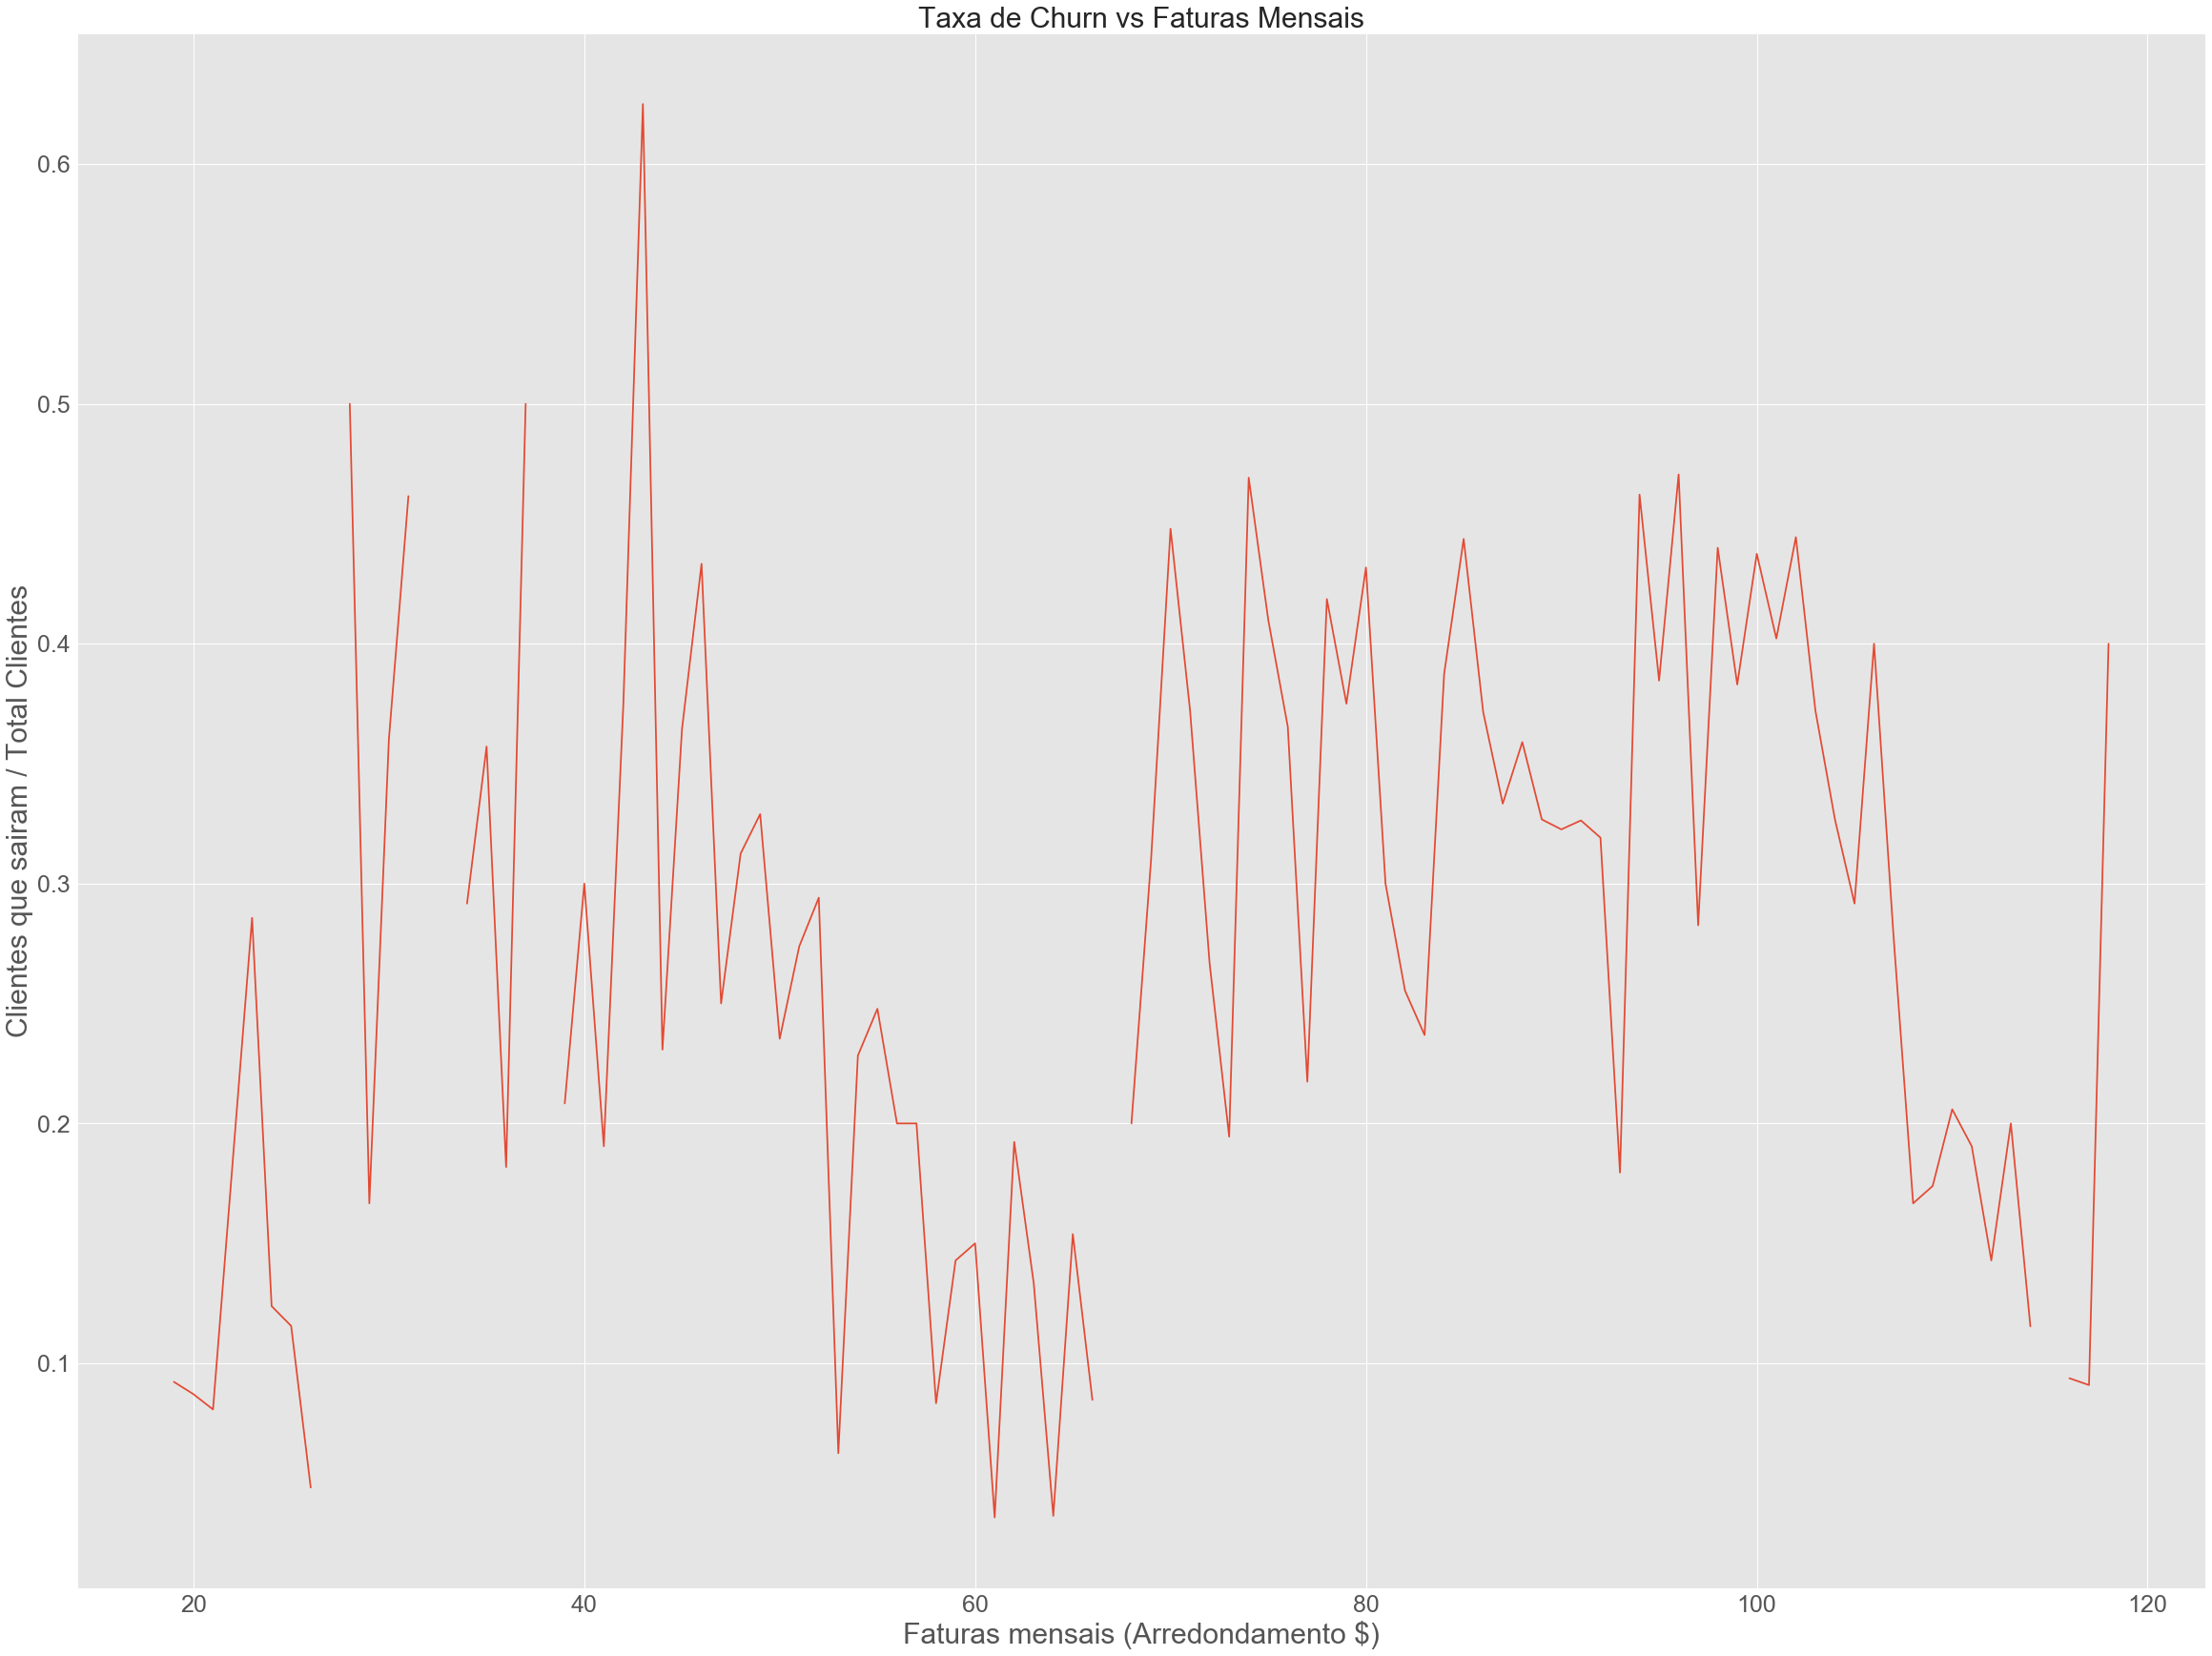

In [24]:
# Faturas mensais

df_churn.MonthlyCharges = df_churn.MonthlyCharges.round()

MonthlyCharges_Churn = df_churn[df_churn.Churn == 'Yes'].groupby('MonthlyCharges').count()['customerID']
MonthlyCharges_NC = df_churn.groupby('MonthlyCharges').count()['customerID']
MonthlyCharges_ratio = MonthlyCharges_Churn/MonthlyCharges_NC

print(MonthlyCharges_ratio)

MonthlyCharges_ratio.plot()
plt.title('Taxa de Churn vs Faturas Mensais',size =30)
plt.xlabel('Faturas mensais (Arredondamento $)', size = 30)
_ = plt.ylabel('Clientes que sairam / Total Clientes', size = 30)
plt.tick_params(labelsize=25)
plt.rcParams['figure.figsize']=(40,30)


print ('''
As cobranças mensais foram arredondadas.
Parece que há uma distribuição bimodal para churning baseada em cobranças mensais.
Os dois modos estão em torno de $30- $40 e $70- $100.''')


__Passo 4.2:__ Excluirei variaveis: Gender, PhoneService e MultipleLines pois nao afetam o churn

In [25]:
# Podemos eliminar algumas variaveis
to_drop = ['gender','PhoneService', 'MultipleLines']
df_churn = df_churn.drop(to_drop,axis = 1)

In [26]:
df_churn.head(10)

,customerID,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,Yes,No,1,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,30.0,29.85,No
1,5575-GNVDE,0,No,No,34,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,57.0,1889.5,No
2,3668-QPYBK,0,No,No,2,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,54.0,108.15,Yes
3,7795-CFOCW,0,No,No,45,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.0,1840.75,No
4,9237-HQITU,0,No,No,2,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,71.0,151.65,Yes
5,9305-CDSKC,0,No,No,8,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,100.0,820.5,Yes
6,1452-KIOVK,0,No,Yes,22,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.0,1949.4,No
7,6713-OKOMC,0,No,No,10,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,30.0,301.9,No
8,7892-POOKP,0,Yes,No,28,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,105.0,3046.05,Yes
9,6388-TABGU,0,No,Yes,62,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.0,3487.95,No


__Passo 4.3:__ Inspecionando a distribuição do campo churn.

# churns: 1869 
# NoChurns: 5174 


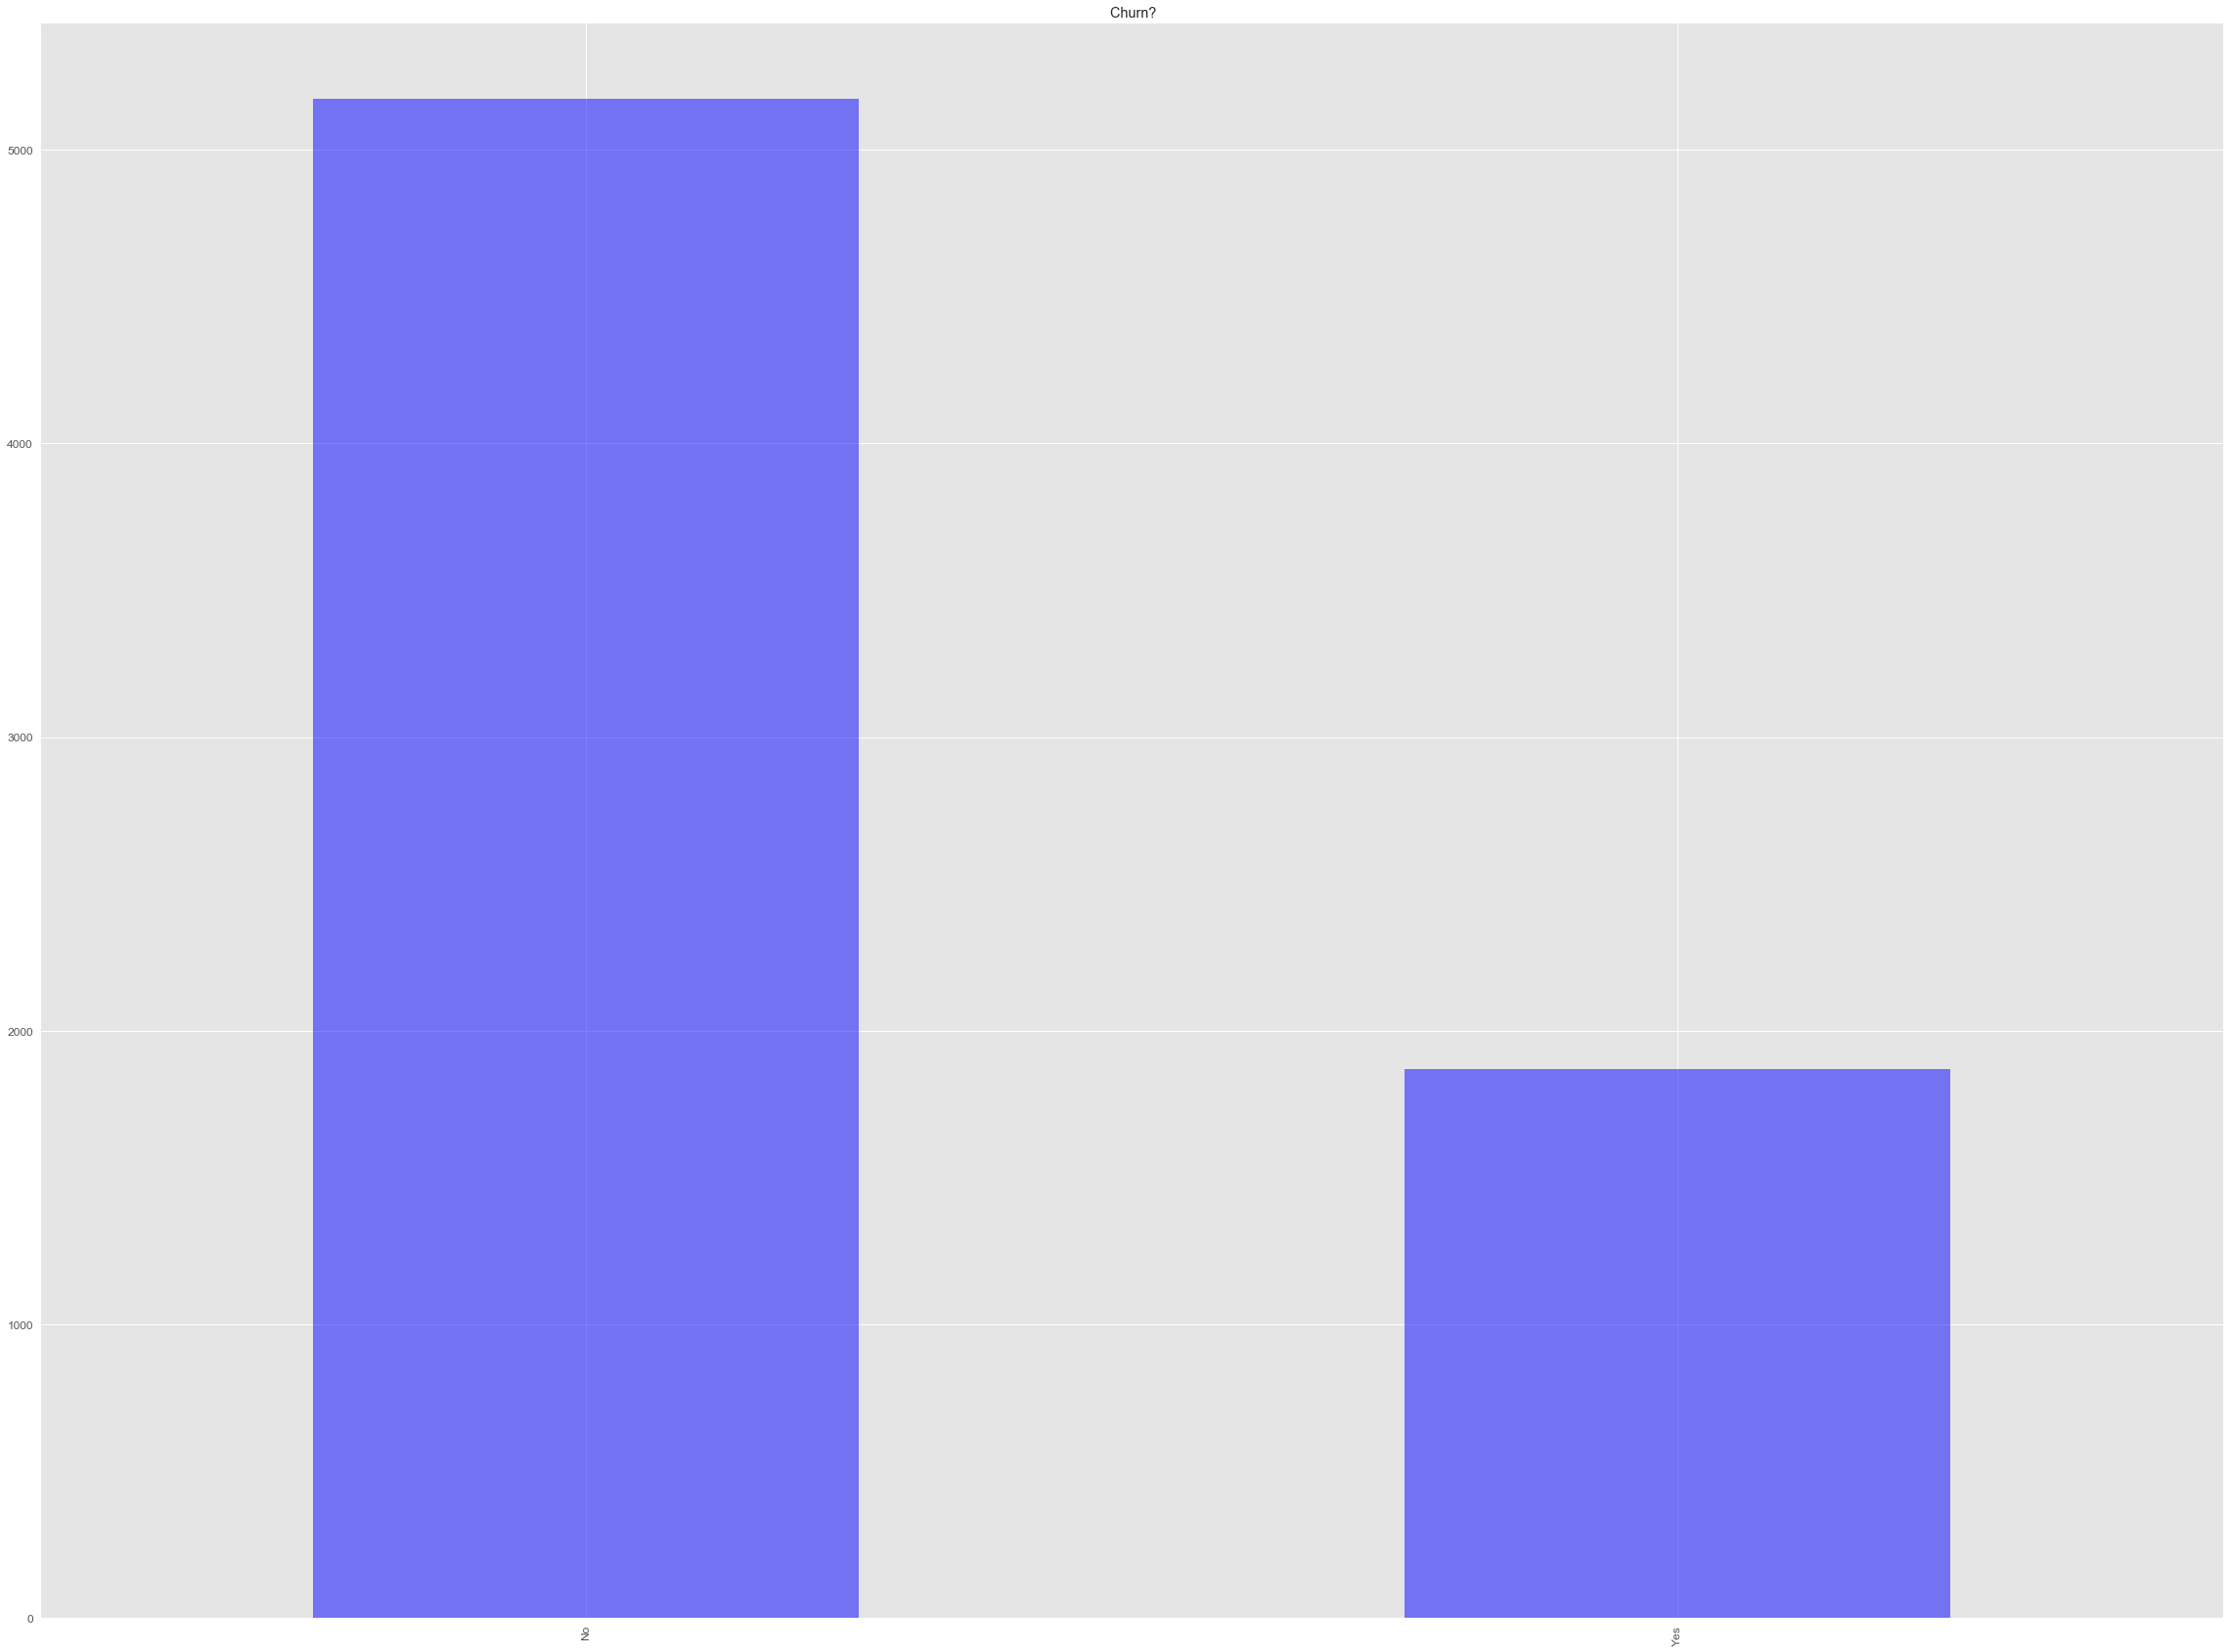

In [34]:
# numero de churns e nao churns
Churns = df_churn[df_churn.Churn == 'Yes'].count()['customerID']
NoChurns = df_churn[df_churn.Churn == 'No'].count()['customerID']
print('# churns: %s ' %Churns)
print('# NoChurns: %s '%NoChurns)

churn_result = df_churn['Churn']
churn_result.to_frame().applymap(lambda x: x.replace('.',''))['Churn'].value_counts().plot(kind = 'bar', color = 'blue', alpha = 0.5, title = ' Churn?');

### __Passo 5 :__ Aplicando e comparando os modelos: Decision Tree, KNN e Random Forest

Algumas métricas e termos úteis para avaliar os modelos de classificação:

- P, número de elementos positivos no conjunto de dados de teste.

- N, número de elementos negativos no conjunto de dados de teste.

- True Positives (TP): número de elementos positivos classificados como positivos.

- False Positives (FP): número de elementos negativos classificados como positivos.

- True Negatives (TN): número de elementos negativos classificados como negativos.

- False Negatives (FN): número de elementos positivos classificados como negativos.


- ** Acurácia **: Frequência de previsões corretas.

$\text{Accuracy} = \frac{TP + TN}{P + N}$

- ** Precisão **: Valor preditivo positivo em toda a amostra.

$\text{Precision} = \frac{TP}{TP + FP}$

- ** Sensibilidade ** (Recall): Proporção de valores positivos corretamente previstos.

$\text{Recall} = \frac{TP}{TP + FN}$

- ** F1-Score **: Combina precisão e sensibilidade na mesma métrica que a média harmônica de ambos.

$\text{F1-Score} = 2\frac{\text{Precision} * \text{Recall}}{\text{Precision} + \text{Recall}}$



ROC Curve: TPR (true positive rate) x FPR (false positive rate).

TPR - True Positive Rate - Porcentagem de instâncias positivas que identificamos corretamente

FPR - False Positive Rate - Porcentagem de instâncias negativas que marcamos como positiva

Specificity (True negative rate) - Nosso alvo - A melhor especificidade é 1, enquanto a pior é 0. TNR (SP) = TN / (TN + FP)

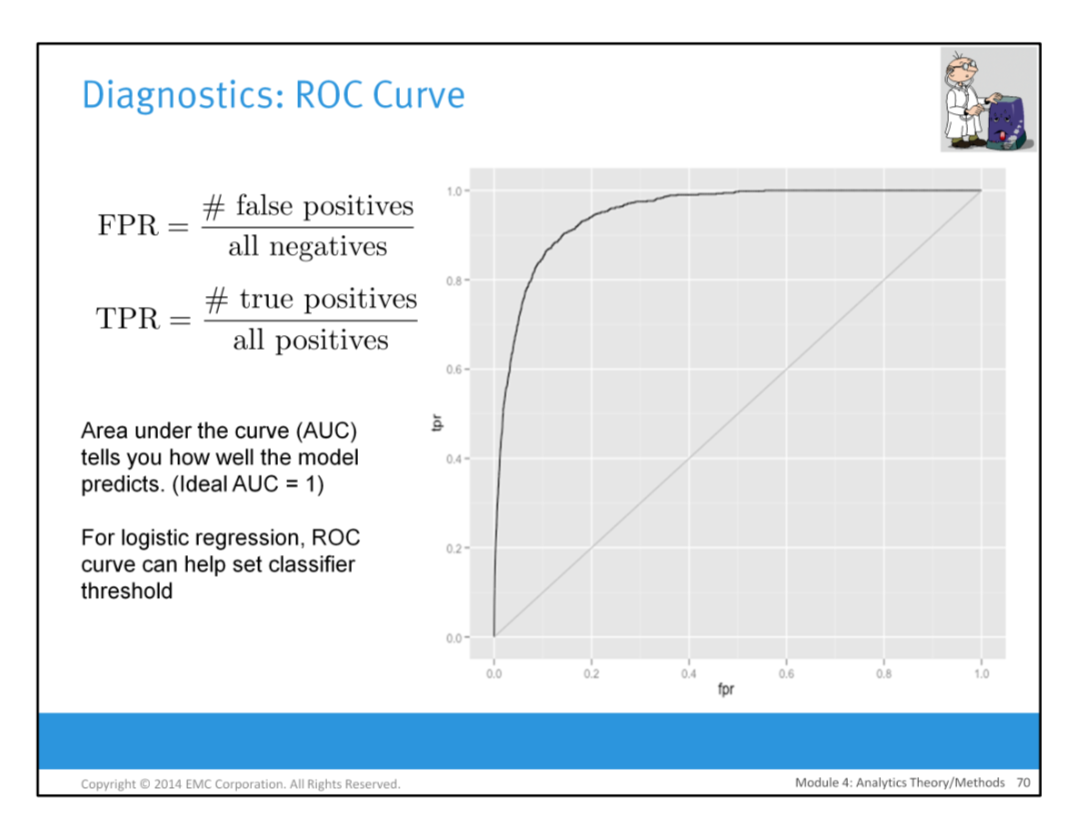

In [64]:
Image(filename='Roc_Curve.png')

#### Avaliando churn pelos atributos demograficos (SeniorCitizen + Partner + Dependents + gender)

In [35]:
formula = 'Churn ~ SeniorCitizen + Partner + Dependents'
y, X = dmatrices(formula, df_churn)
target = y
target_hat = y.copy()
features_matrix = X

In [36]:
print("target: ", target.shape)
print("matriz dos atributos: ", features_matrix.shape)

('target: ', (7043, 2))
('matriz dos atributos: ', (7043, 4))


Acuracia media dt atributos demograficos: 0.73 


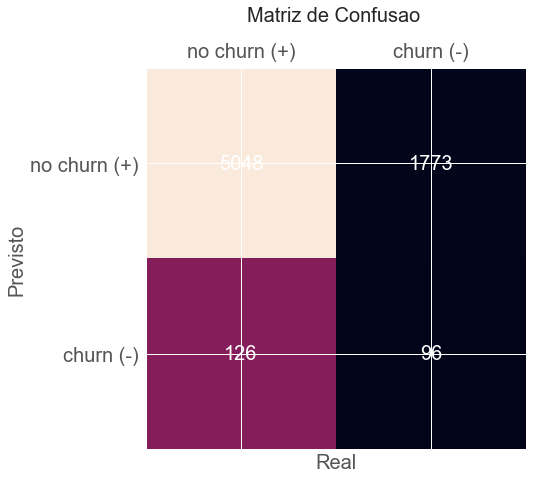

             precision    recall  f1-score   support

          0       0.74      0.98      0.84      5174
          1       0.43      0.05      0.09      1869

avg / total       0.66      0.73      0.64      7043



In [37]:
# =====================================
# decision tree - atributos demograficos
# =====================================
from sklearn import tree

# validacao cruzada
kf=cross_validation.KFold(n = target.shape[0], n_folds=5, shuffle=True, random_state=0)
acc = np.zeros((5,))
i=0

for train_index, test_index in kf:
    feat_train, feat_test = features_matrix[train_index], features_matrix[test_index]
    target_train, target_test = target[train_index], target[test_index]
    dt = tree.DecisionTreeClassifier(criterion='gini')
    dt.fit(feat_train,target_train)
    target_hat[test_index] = dt.predict(feat_test)
    acc[i] = metrics.accuracy_score(target_hat[test_index], target_test)
    i=i+1
    
print ('Acuracia media dt atributos demograficos: %s ' %round(np.mean(acc),2))

cm = metrics.confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(cm)
plt.title('Matriz de Confusao \n',size=20)
ax.set_xticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
ax.set_yticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
plt.ylabel('Previsto',size=20)
plt.xlabel('Real',size=20)
for i in range(2):
    for j in range(2):
        ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
fig.set_size_inches(7,7)
plt.show()

print (metrics.classification_report(target,target_hat))


In [38]:
# Curva ROC e metricas
tp, fn, fp, tn = confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1)).ravel()
print("- True Positives (TP): %s elementos positivos classificados como positivos." %tp)
print("- False Positives (FP): %s elementos negativos classificados como positivos." %fp)
print("- True Negatives (TN): %s elementos negativos classificados como negativos." %tn)
print("- False Negatives (FN): %s elementos positivos classificados como negativos." %fn)
print("")
specificity = round(tn / (tn+fp),2)

fpr, tpr, thresholds = metrics.roc_curve(target.argmax(axis=1), target_hat.argmax(axis=1))
print("AUC dt atributos demograficos: %s" %round(metrics.auc(fpr, tpr),2))
print("Especificidade dt atributos demograficos: %s" %specificity)

- True Positives (TP): 5048 elementos positivos classificados como positivos.
- False Positives (FP): 1773 elementos negativos classificados como positivos.
- True Negatives (TN): 96 elementos negativos classificados como negativos.
- False Negatives (FN): 126 elementos positivos classificados como negativos.

AUC dt atributos demograficos: 0.51
Especificidade dt atributos demograficos: 0.05


Acuracia media KNN atributos demograficos: 0.68


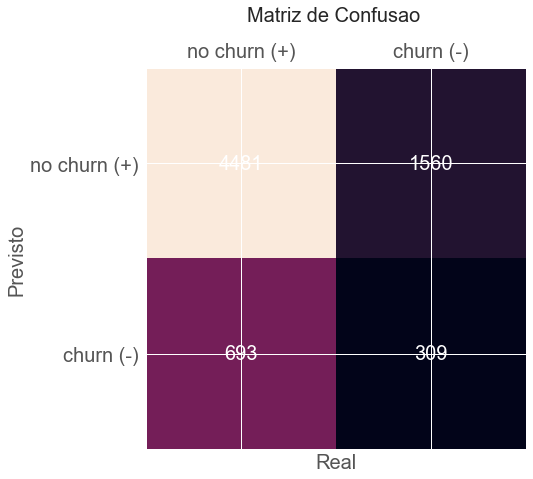

             precision    recall  f1-score   support

          0       0.74      0.87      0.80      5174
          1       0.31      0.17      0.22      1869

avg / total       0.63      0.68      0.64      7043



In [39]:
# =====================================
#  KNN - atributos demograficos
# =====================================

from sklearn import neighbors


kf=cross_validation.KFold(n = target.shape[0], n_folds=5, shuffle=True, random_state=0)
acc = np.zeros((5,))
i=0

for train_index, test_index in kf:
    feat_train, feat_test = features_matrix[train_index], features_matrix[test_index]
    target_train, target_test = target[train_index], target[test_index]
    knn = neighbors.KNeighborsClassifier(n_neighbors = 3)
    knn.fit(feat_train,target_train)
    target_hat[test_index] = knn.predict(feat_test)
    acc[i] = metrics.accuracy_score(target_hat[test_index], target_test)
    i = i+1
    
print ('Acuracia media KNN atributos demograficos: %s' %round(np.mean(acc),2))

cm = metrics.confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(cm)
plt.title('Matriz de Confusao \n',size=20)
ax.set_xticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
ax.set_yticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
plt.ylabel('Previsto',size=20)
plt.xlabel('Real',size=20)
for i in range(2):
    for j in range(2):
        ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
fig.set_size_inches(7,7)
plt.show()

print (metrics.classification_report(target,target_hat))


In [40]:
# Curva ROC e metricas
tp, fn, fp, tn = confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1)).ravel()
print("- True Positives (TP): %s elementos positivos classificados como positivos." %tp)
print("- False Positives (FP): %s elementos negativos classificados como positivos." %fp)
print("- True Negatives (TN): %s elementos negativos classificados como negativos." %tn)
print("- False Negatives (FN): %s elementos positivos classificados como negativos." %fn)
print("")
specificity = round(tn / (tn+fp),2)

fpr, tpr, thresholds = metrics.roc_curve(target.argmax(axis=1), target_hat.argmax(axis=1))
print("AUC KNN atributos demograficos: %s" %round(metrics.auc(fpr, tpr),2))
print("Especificidade KNN atributos demograficos: %s" %specificity)

- True Positives (TP): 4481 elementos positivos classificados como positivos.
- False Positives (FP): 1560 elementos negativos classificados como positivos.
- True Negatives (TN): 309 elementos negativos classificados como negativos.
- False Negatives (FN): 693 elementos positivos classificados como negativos.

AUC KNN atributos demograficos: 0.52
Especificidade KNN atributos demograficos: 0.17


Acuracia media Randon Forest atributos demograficos: 0.73 


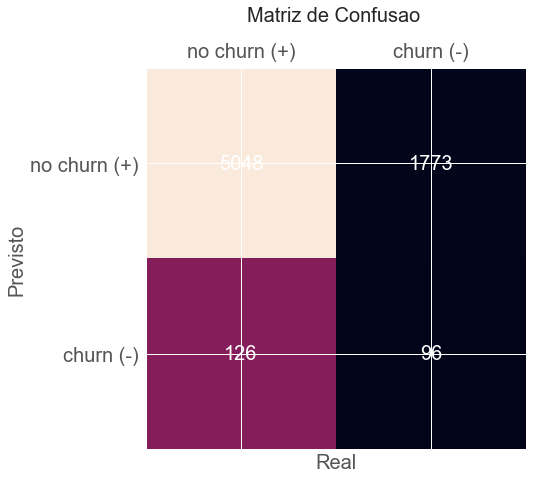

             precision    recall  f1-score   support

          0       0.74      0.98      0.84      5174
          1       0.43      0.05      0.09      1869

avg / total       0.66      0.73      0.64      7043



In [41]:
# =====================================
#  Randon Forest - atributos demograficos
# =====================================

from sklearn.ensemble import RandomForestClassifier

n_estimator = 10

kf=cross_validation.KFold(n=target.shape[0], n_folds=5, shuffle=True, random_state=0)
acc = np.zeros((5,))
i=0

for train_index, test_index in kf:
    feat_train, feat_test = features_matrix[train_index], features_matrix[test_index]
    target_train, target_test = target[train_index], target[test_index]
    rf = RandomForestClassifier(max_depth=30, n_estimators=n_estimator)
    rf.fit(feat_train, target_train)
    target_hat[test_index] = rf.predict(feat_test)
    acc[i] = metrics.accuracy_score(target_hat[test_index], target_test)
    i=i+1
    
print ('Acuracia media Randon Forest atributos demograficos: %s ' %round(np.mean(acc),2))

cm = metrics.confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(cm)
plt.title('Matriz de Confusao \n',size=20)
ax.set_xticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
ax.set_yticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
plt.ylabel('Previsto',size=20)
plt.xlabel('Real',size=20)
for i in range(2):
    for j in range(2):
        ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
fig.set_size_inches(7,7)
plt.show()

print (metrics.classification_report(target,target_hat))

In [42]:
# Curva ROC e metricas
tp, fn, fp, tn = confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1)).ravel()
print("- True Positives (TP): %s elementos positivos classificados como positivos." %tp)
print("- False Positives (FP): %s elementos negativos classificados como positivos." %fp)
print("- True Negatives (TN): %s elementos negativos classificados como negativos." %tn)
print("- False Negatives (FN): %s elementos positivos classificados como negativos." %fn)
print("")
specificity = round(tn / (tn+fp),2)

fpr, tpr, thresholds = metrics.roc_curve(target.argmax(axis=1), target_hat.argmax(axis=1))
print("AUC Random Forest atributos demograficos: %s" %round(metrics.auc(fpr, tpr),2))
print("Especificidade Random Forest atributos demograficos: %s" %specificity)

- True Positives (TP): 5048 elementos positivos classificados como positivos.
- False Positives (FP): 1773 elementos negativos classificados como positivos.
- True Negatives (TN): 96 elementos negativos classificados como negativos.
- False Negatives (FN): 126 elementos positivos classificados como negativos.

AUC Random Forest atributos demograficos: 0.51
Especificidade Random Forest atributos demograficos: 0.05


### Avaliando churn pelos os servicos contratados (PhoneService + MultipleLines + InternetService + OnlineBackup + OnlineSecurity + DeviceProtection + TechSupport + StreamingTV + StreamingMovies)

In [43]:
formula = 'Churn ~ InternetService + OnlineBackup + OnlineSecurity + DeviceProtection + TechSupport + StreamingTV + StreamingMovies'
y, X = dmatrices(formula, df_churn)
target = y
target_hat = y.copy()
features_matrix = X

In [44]:
print("target: ", target.shape)
print("matriz dos atributos: ", features_matrix.shape)

('target: ', (7043, 2))
('matriz dos atributos: ', (7043, 15))


Acuracia media dt servicos contratados: 0.75


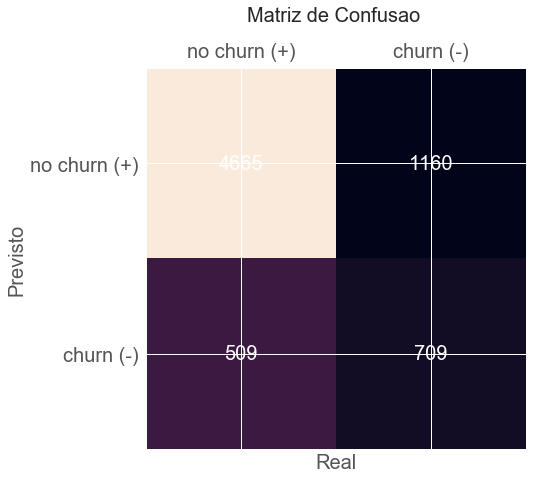

             precision    recall  f1-score   support

          0       0.81      0.89      0.85      5174
          1       0.58      0.38      0.46      1869

avg / total       0.75      0.75      0.74      7043



In [45]:
# =====================================
# decision tree -  servicos contratados
# =====================================
from sklearn import tree

# validacao cruzada
kf=cross_validation.KFold(n = target.shape[0], n_folds=5, shuffle=True, random_state=0)
acc = np.zeros((5,))
i=0

for train_index, test_index in kf:
    feat_train, feat_test = features_matrix[train_index], features_matrix[test_index]
    target_train, target_test = target[train_index], target[test_index]
    dt = tree.DecisionTreeClassifier(criterion='gini')
    dt.fit(feat_train,target_train)
    target_hat[test_index] = dt.predict(feat_test)
    acc[i] = metrics.accuracy_score(target_hat[test_index], target_test)
    i=i+1
    
print ('Acuracia media dt servicos contratados: %s' %round(np.mean(acc),2))

cm = metrics.confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(cm)
plt.title('Matriz de Confusao \n',size=20)
ax.set_xticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
ax.set_yticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
plt.ylabel('Previsto',size=20)
plt.xlabel('Real',size=20)
for i in range(2):
    for j in range(2):
        ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
fig.set_size_inches(7,7)
plt.show()

print (metrics.classification_report(target,target_hat))

In [46]:
# Curva ROC e metricas
tp, fn, fp, tn = confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1)).ravel()
print("- True Positives (TP): %s elementos positivos classificados como positivos." %tp)
print("- False Positives (FP): %s elementos negativos classificados como positivos." %fp)
print("- True Negatives (TN): %s elementos negativos classificados como negativos." %tn)
print("- False Negatives (FN): %s elementos positivos classificados como negativos." %fn)
print("")
specificity = round(tn / (tn+fp),2)

fpr, tpr, thresholds = metrics.roc_curve(target.argmax(axis=1), target_hat.argmax(axis=1))
print("AUC dt servicos contratados: %s" %round(metrics.auc(fpr, tpr),2))
print("Especificidade dt servicos contratados: %s" %specificity)

- True Positives (TP): 4665 elementos positivos classificados como positivos.
- False Positives (FP): 1160 elementos negativos classificados como positivos.
- True Negatives (TN): 709 elementos negativos classificados como negativos.
- False Negatives (FN): 509 elementos positivos classificados como negativos.

AUC dt servicos contratados: 0.64
Especificidade dt servicos contratados: 0.38


Acuracia media KNN servicos contratados: 0.72


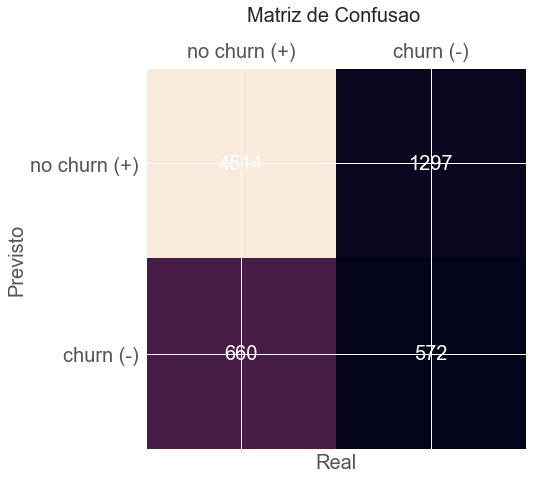

             precision    recall  f1-score   support

          0       0.78      0.87      0.82      5174
          1       0.46      0.31      0.37      1869

avg / total       0.69      0.72      0.70      7043



In [47]:
# =====================================
#  KNN - servicos contratados
# =====================================

from sklearn import neighbors


kf=cross_validation.KFold(n = target.shape[0], n_folds=5, shuffle=True, random_state=0)
acc = np.zeros((5,))
i=0

for train_index, test_index in kf:
    feat_train, feat_test = features_matrix[train_index], features_matrix[test_index]
    target_train, target_test = target[train_index], target[test_index]
    knn = neighbors.KNeighborsClassifier(n_neighbors = 3)
    knn.fit(feat_train,target_train)
    target_hat[test_index] = knn.predict(feat_test)
    acc[i] = metrics.accuracy_score(target_hat[test_index], target_test)
    i = i+1
    
print ('Acuracia media KNN servicos contratados: %s' %round(np.mean(acc),2))

cm = metrics.confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(cm)
plt.title('Matriz de Confusao \n',size=20)
ax.set_xticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
ax.set_yticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
plt.ylabel('Previsto',size=20)
plt.xlabel('Real',size=20)
for i in range(2):
    for j in range(2):
        ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
fig.set_size_inches(7,7)
plt.show()

print (metrics.classification_report(target,target_hat))


In [48]:
# Curva ROC e metricas
tp, fn, fp, tn = confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1)).ravel()
print("- True Positives (TP): %s elementos positivos classificados como positivos." %tp)
print("- False Positives (FP): %s elementos negativos classificados como positivos." %fp)
print("- True Negatives (TN): %s elementos negativos classificados como negativos." %tn)
print("- False Negatives (FN): %s elementos positivos classificados como negativos." %fn)
print("")
specificity = round(tn / (tn+fp),2)

fpr, tpr, thresholds = metrics.roc_curve(target.argmax(axis=1), target_hat.argmax(axis=1))
print("AUC KNN servicos contratados: %s" %round(metrics.auc(fpr, tpr),2))
print("Especificidade KNN servicos contratados: %s" %specificity)

- True Positives (TP): 4514 elementos positivos classificados como positivos.
- False Positives (FP): 1297 elementos negativos classificados como positivos.
- True Negatives (TN): 572 elementos negativos classificados como negativos.
- False Negatives (FN): 660 elementos positivos classificados como negativos.

AUC KNN servicos contratados: 0.59
Especificidade KNN servicos contratados: 0.31


Acuracia media Randon Forest servicos contratados: 0.76 


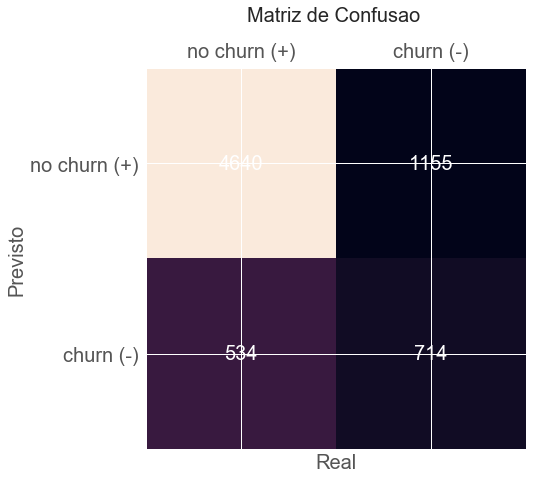

             precision    recall  f1-score   support

          0       0.80      0.90      0.85      5174
          1       0.57      0.38      0.46      1869

avg / total       0.74      0.76      0.74      7043



In [49]:
# =====================================
#  Randon Forest - servicos contratados
# =====================================

from sklearn.ensemble import RandomForestClassifier

n_estimator = 10

kf=cross_validation.KFold(n=target.shape[0], n_folds=5, shuffle=True, random_state=0)
acc = np.zeros((5,))
i=0

for train_index, test_index in kf:
    feat_train, feat_test = features_matrix[train_index], features_matrix[test_index]
    target_train, target_test = target[train_index], target[test_index]
    rf = RandomForestClassifier(max_depth=30, n_estimators=n_estimator)
    rf.fit(feat_train, target_train)
    target_hat[test_index] = rf.predict(feat_test)
    acc[i] = metrics.accuracy_score(target_hat[test_index], target_test)
    i=i+1
    
print ('Acuracia media Randon Forest servicos contratados: %s ' %round(np.mean(acc),2))

cm = metrics.confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(cm)
plt.title('Matriz de Confusao \n',size=20)
ax.set_xticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
ax.set_yticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
plt.ylabel('Previsto',size=20)
plt.xlabel('Real',size=20)
for i in range(2):
    for j in range(2):
        ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
fig.set_size_inches(7,7)
plt.show()

print (metrics.classification_report(target,target_hat))

In [50]:
# Curva ROC e metricas
tp, fn, fp, tn = confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1)).ravel()
print("- True Positives (TP): %s elementos positivos classificados como positivos." %tp)
print("- False Positives (FP): %s elementos negativos classificados como positivos." %fp)
print("- True Negatives (TN): %s elementos negativos classificados como negativos." %tn)
print("- False Negatives (FN): %s elementos positivos classificados como negativos." %fn)
print("")
specificity = round(tn / (tn+fp),2)

fpr, tpr, thresholds = metrics.roc_curve(target.argmax(axis=1), target_hat.argmax(axis=1))
print("AUC Random Forest servicos contratados: %s" %round(metrics.auc(fpr, tpr),2))
print("Especificidade Random Forest servicos contratados: %s" %specificity)

- True Positives (TP): 4640 elementos positivos classificados como positivos.
- False Positives (FP): 1155 elementos negativos classificados como positivos.
- True Negatives (TN): 714 elementos negativos classificados como negativos.
- False Negatives (FN): 534 elementos positivos classificados como negativos.

AUC Random Forest servicos contratados: 0.64
Especificidade Random Forest servicos contratados: 0.38


## Avaliando churn pelos atributos de pagamento/conta (tenure + MonthlyCharges + TotalCharges + Contract + PaperlessBilling + PaymentMethod)

In [51]:
formula = 'Churn ~ tenure + MonthlyCharges + TotalCharges + Contract + PaperlessBilling + PaymentMethod'
y, X = dmatrices(formula, df_churn)
target = y
target_hat = y.copy()
features_matrix = X

In [52]:
print("target: ", target.shape)
print("matriz dos atributos: ", features_matrix.shape)

('target: ', (7043, 2))
('matriz dos atributos: ', (7043, 6539))


Acuracia media dt atributos de pagamento/conta: 0.78


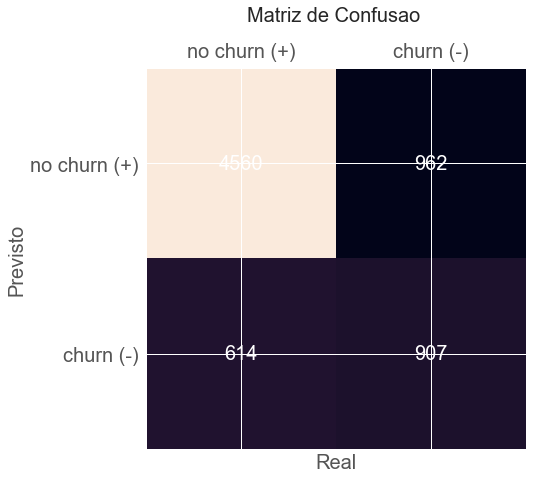

             precision    recall  f1-score   support

          0       0.83      0.88      0.85      5174
          1       0.60      0.49      0.54      1869

avg / total       0.77      0.78      0.77      7043



In [53]:
# =====================================
# decision tree -  atributos de pagamento/conta
# =====================================
from sklearn import tree

# validacao cruzada
kf=cross_validation.KFold(n = target.shape[0], n_folds=5, shuffle=True, random_state=0)
acc = np.zeros((5,))
i=0

for train_index, test_index in kf:
    feat_train, feat_test = features_matrix[train_index], features_matrix[test_index]
    target_train, target_test = target[train_index], target[test_index]
    dt = tree.DecisionTreeClassifier(criterion='gini')
    dt.fit(feat_train,target_train)
    target_hat[test_index] = dt.predict(feat_test)
    acc[i] = metrics.accuracy_score(target_hat[test_index], target_test)
    i=i+1
    
print ('Acuracia media dt atributos de pagamento/conta: %s' %round(np.mean(acc),2))

cm = metrics.confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(cm)
plt.title('Matriz de Confusao \n',size=20)
ax.set_xticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
ax.set_yticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
plt.ylabel('Previsto',size=20)
plt.xlabel('Real',size=20)
for i in range(2):
    for j in range(2):
        ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
fig.set_size_inches(7,7)
plt.show()

print (metrics.classification_report(target,target_hat))

In [54]:
# Curva ROC e metricas
tp, fn, fp, tn = confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1)).ravel()
print("- True Positives (TP): %s elementos positivos classificados como positivos." %tp)
print("- False Positives (FP): %s elementos negativos classificados como positivos." %fp)
print("- True Negatives (TN): %s elementos negativos classificados como negativos." %tn)
print("- False Negatives (FN): %s elementos positivos classificados como negativos." %fn)
print("")
specificity = round(tn / (tn+fp),2)

fpr, tpr, thresholds = metrics.roc_curve(target.argmax(axis=1), target_hat.argmax(axis=1))
print("AUC dt atributos de pagamento: %s" %round(metrics.auc(fpr, tpr),2))
print("Especificidade dt atributos de pagamento: %s" %specificity)

- True Positives (TP): 4560 elementos positivos classificados como positivos.
- False Positives (FP): 962 elementos negativos classificados como positivos.
- True Negatives (TN): 907 elementos negativos classificados como negativos.
- False Negatives (FN): 614 elementos positivos classificados como negativos.

AUC dt atributos de pagamento: 0.68
Especificidade dt atributos de pagamento: 0.49


Acuracia media KNN atributos de pagamento/conta: 0.76 


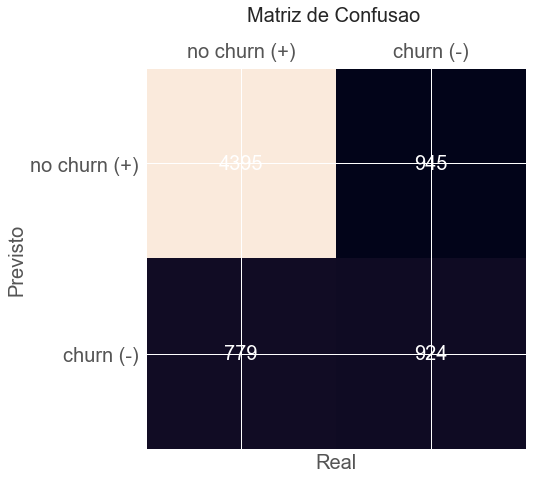

             precision    recall  f1-score   support

          0       0.82      0.85      0.84      5174
          1       0.54      0.49      0.52      1869

avg / total       0.75      0.76      0.75      7043



In [55]:
# =====================================
#  KNN - atributos de pagamento/conta
# =====================================

from sklearn import neighbors

kf=cross_validation.KFold(n = target.shape[0], n_folds=5, shuffle=True, random_state=0)
acc = np.zeros((5,))
i=0

for train_index, test_index in kf:
    feat_train, feat_test = features_matrix[train_index], features_matrix[test_index]
    target_train, target_test = target[train_index], target[test_index]
    knn = neighbors.KNeighborsClassifier(n_neighbors = 3)
    knn.fit(feat_train,target_train)
    target_hat[test_index] = knn.predict(feat_test)
    acc[i] = metrics.accuracy_score(target_hat[test_index], target_test)
    i = i+1
    
print ('Acuracia media KNN atributos de pagamento/conta: %s ' %round(np.mean(acc),2))

cm = metrics.confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(cm)
plt.title('Matriz de Confusao \n',size=20)
ax.set_xticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
ax.set_yticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
plt.ylabel('Previsto',size=20)
plt.xlabel('Real',size=20)
for i in range(2):
    for j in range(2):
        ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
fig.set_size_inches(7,7)
plt.show()

print (metrics.classification_report(target,target_hat))


In [56]:
# Curva ROC e metricas
tp, fn, fp, tn = confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1)).ravel()
print("- True Positives (TP): %s elementos positivos classificados como positivos." %tp)
print("- False Positives (FP): %s elementos negativos classificados como positivos." %fp)
print("- True Negatives (TN): %s elementos negativos classificados como negativos." %tn)
print("- False Negatives (FN): %s elementos positivos classificados como negativos." %fn)
print("")
specificity = round(tn / (tn+fp),2)

fpr, tpr, thresholds = metrics.roc_curve(target.argmax(axis=1), target_hat.argmax(axis=1))
print("AUC KNN atributos pagamento: %s" %round(metrics.auc(fpr, tpr),2))
print("Especificidade KNN atributos de pagamento: %s" %specificity)

- True Positives (TP): 4395 elementos positivos classificados como positivos.
- False Positives (FP): 945 elementos negativos classificados como positivos.
- True Negatives (TN): 924 elementos negativos classificados como negativos.
- False Negatives (FN): 779 elementos positivos classificados como negativos.

AUC KNN atributos pagamento: 0.67
Especificidade KNN atributos de pagamento: 0.49


Acuracia media Randon Forest atributos de pagamento/conta: 0.75 


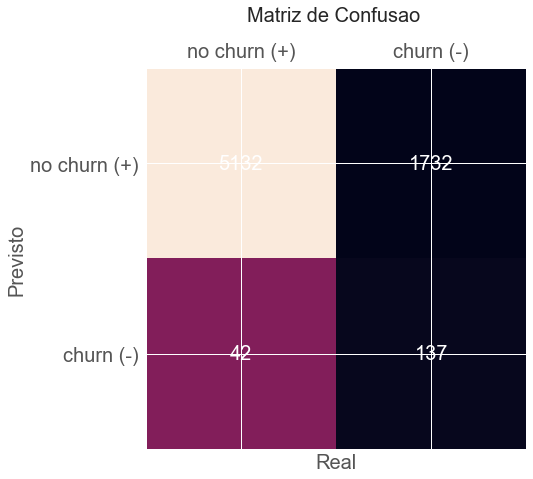

             precision    recall  f1-score   support

          0       0.75      0.99      0.85      5174
          1       0.77      0.07      0.13      1869

avg / total       0.75      0.75      0.66      7043



In [57]:
# =====================================
#  Randon Forest - atributos de pagamento/conta
# =====================================

from sklearn.ensemble import RandomForestClassifier

n_estimator = 10

kf=cross_validation.KFold(n=target.shape[0], n_folds=5, shuffle=True, random_state=0)
acc = np.zeros((5,))
i=0

for train_index, test_index in kf:
    feat_train, feat_test = features_matrix[train_index], features_matrix[test_index]
    target_train, target_test = target[train_index], target[test_index]
    rf = RandomForestClassifier(max_depth=30, n_estimators=n_estimator)
    rf.fit(feat_train, target_train)
    target_hat[test_index] = rf.predict(feat_test)
    acc[i] = metrics.accuracy_score(target_hat[test_index], target_test)
    i=i+1
    
print ('Acuracia media Randon Forest atributos de pagamento/conta: %s ' %round(np.mean(acc),2))

cm = metrics.confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(cm)
plt.title('Matriz de Confusao \n',size=20)
ax.set_xticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
ax.set_yticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
plt.ylabel('Previsto',size=20)
plt.xlabel('Real',size=20)
for i in range(2):
    for j in range(2):
        ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
fig.set_size_inches(7,7)
plt.show()

print (metrics.classification_report(target,target_hat))

In [58]:
# Curva ROC e metricas
tp, fn, fp, tn = confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1)).ravel()
print("- True Positives (TP): %s elementos positivos classificados como positivos." %tp)
print("- False Positives (FP): %s elementos negativos classificados como positivos." %fp)
print("- True Negatives (TN): %s elementos negativos classificados como negativos." %tn)
print("- False Negatives (FN): %s elementos positivos classificados como negativos." %fn)
print("")
specificity = round(tn / (tn+fp),2)

fpr, tpr, thresholds = metrics.roc_curve(target.argmax(axis=1), target_hat.argmax(axis=1))
print("AUC Randon Forest atributos de pagamento: %s" %round(metrics.auc(fpr, tpr),2))
print("Especificidade Randon Forest atributos de pagamento: %s" %specificity)

- True Positives (TP): 5132 elementos positivos classificados como positivos.
- False Positives (FP): 1732 elementos negativos classificados como positivos.
- True Negatives (TN): 137 elementos negativos classificados como negativos.
- False Negatives (FN): 42 elementos positivos classificados como negativos.

AUC Randon Forest atributos de pagamento: 0.53
Especificidade Randon Forest atributos de pagamento: 0.07



## Avaliando todos os atributos (features) ao mesmo tempo 

In [59]:
formula = 'Churn ~ tenure + MonthlyCharges + TotalCharges + Contract + PaperlessBilling + PaymentMethod + InternetService + OnlineBackup + OnlineSecurity + DeviceProtection + TechSupport + StreamingTV + StreamingMovies + SeniorCitizen + Partner + Dependents'
y, X = dmatrices(formula, df_churn)
target = y
target_hat = y.copy()
features_matrix = X

In [60]:
print("target: ", target.shape)
print("matriz dos atributos: ", features_matrix.shape)

('target: ', (7043, 2))
('matriz dos atributos: ', (7043, 6556))


Acuracia media dt todos os atributos: 0.78 


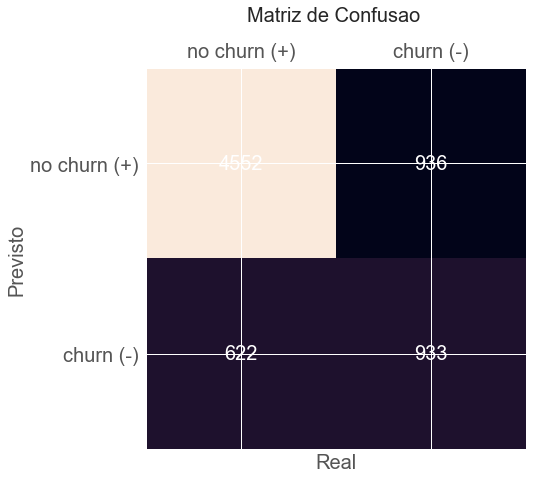

             precision    recall  f1-score   support

          0       0.83      0.88      0.85      5174
          1       0.60      0.50      0.54      1869

avg / total       0.77      0.78      0.77      7043



In [61]:
# =====================================
# decision tree -  todos os atributos
# =====================================
from sklearn import tree

# validacao cruzada
kf=cross_validation.KFold(n = target.shape[0], n_folds=5, shuffle=True, random_state=0)
acc = np.zeros((5,))
i=0

for train_index, test_index in kf:
    feat_train, feat_test = features_matrix[train_index], features_matrix[test_index]
    target_train, target_test = target[train_index], target[test_index]
    dt = tree.DecisionTreeClassifier(criterion='gini')
    dt.fit(feat_train,target_train)
    target_hat[test_index] = dt.predict(feat_test)
    acc[i] = metrics.accuracy_score(target_hat[test_index], target_test)
    i=i+1
    
print ('Acuracia media dt todos os atributos: %s ' %round(np.mean(acc),2))

cm = metrics.confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(cm)
plt.title('Matriz de Confusao \n',size=20)
ax.set_xticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
ax.set_yticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
plt.ylabel('Previsto',size=20)
plt.xlabel('Real',size=20)
for i in range(2):
    for j in range(2):
        ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
fig.set_size_inches(7,7)
plt.show()

print (metrics.classification_report(target,target_hat))

In [62]:
# Curva ROC e metricas
tp, fn, fp, tn = confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1)).ravel()
print("- True Positives (TP): %s elementos positivos classificados como positivos." %tp)
print("- False Positives (FP): %s elementos negativos classificados como positivos." %fp)
print("- True Negatives (TN): %s elementos negativos classificados como negativos." %tn)
print("- False Negatives (FN): %s elementos positivos classificados como negativos." %fn)
print("")
specificity = round(tn / (tn+fp),2)

fpr, tpr, thresholds = metrics.roc_curve(target.argmax(axis=1), target_hat.argmax(axis=1))
print("AUC dt todos os atributos: %s" %round(metrics.auc(fpr, tpr),2))
print("Especificidade dt todos os atributos: %s" %specificity)

- True Positives (TP): 4552 elementos positivos classificados como positivos.
- False Positives (FP): 936 elementos negativos classificados como positivos.
- True Negatives (TN): 933 elementos negativos classificados como negativos.
- False Negatives (FN): 622 elementos positivos classificados como negativos.

AUC dt todos os atributos: 0.69
Especificidade dt todos os atributos: 0.5


Acuracia media KNN todos os atributos: 0.76 


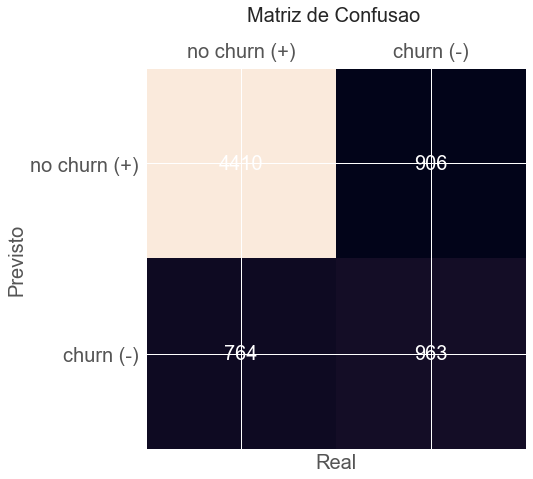

             precision    recall  f1-score   support

          0       0.83      0.85      0.84      5174
          1       0.56      0.52      0.54      1869

avg / total       0.76      0.76      0.76      7043



In [63]:
# =====================================
#  KNN - todos oa atributos
# =====================================

from sklearn import neighbors


kf=cross_validation.KFold(n = target.shape[0], n_folds=5, shuffle=True, random_state=0)
acc = np.zeros((5,))
i=0

for train_index, test_index in kf:
    feat_train, feat_test = features_matrix[train_index], features_matrix[test_index]
    target_train, target_test = target[train_index], target[test_index]
    knn = neighbors.KNeighborsClassifier(n_neighbors = 3)
    knn.fit(feat_train,target_train)
    target_hat[test_index] = knn.predict(feat_test)
    acc[i] = metrics.accuracy_score(target_hat[test_index], target_test)
    i = i+1
    
print ('Acuracia media KNN todos os atributos: %s ' %round(np.mean(acc),2))

cm = metrics.confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(cm)
plt.title('Matriz de Confusao \n',size=20)
ax.set_xticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
ax.set_yticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
plt.ylabel('Previsto',size=20)
plt.xlabel('Real',size=20)
for i in range(2):
    for j in range(2):
        ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
fig.set_size_inches(7,7)
plt.show()

print (metrics.classification_report(target,target_hat))


In [64]:
# Curva ROC e metricas
tp, fn, fp, tn = confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1)).ravel()
print("- True Positives (TP): %s elementos positivos classificados como positivos." %tp)
print("- False Positives (FP): %s elementos negativos classificados como positivos." %fp)
print("- True Negatives (TN): %s elementos negativos classificados como negativos." %tn)
print("- False Negatives (FN): %s elementos positivos classificados como negativos." %fn)
print("")
specificity = round(tn / (tn+fp),2)

fpr, tpr, thresholds = metrics.roc_curve(target.argmax(axis=1), target_hat.argmax(axis=1))
print("AUC KNN todos os atributos: %s" %round(metrics.auc(fpr, tpr),2))
print("Especificidade KNN todos os atributos: %s" %specificity)

- True Positives (TP): 4410 elementos positivos classificados como positivos.
- False Positives (FP): 906 elementos negativos classificados como positivos.
- True Negatives (TN): 963 elementos negativos classificados como negativos.
- False Negatives (FN): 764 elementos positivos classificados como negativos.

AUC KNN todos os atributos: 0.68
Especificidade KNN todos os atributos: 0.52


Acuracia media Randon Forest todos os atributos: 0.78 


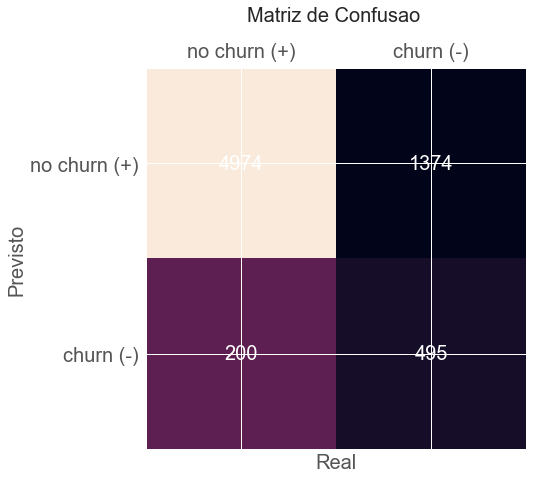

             precision    recall  f1-score   support

          0       0.78      0.96      0.86      5174
          1       0.71      0.26      0.39      1869

avg / total       0.76      0.78      0.74      7043



In [65]:
# =====================================
#  Randon Forest - todos os atributos
# =====================================

from sklearn.ensemble import RandomForestClassifier

n_estimator = 10

kf=cross_validation.KFold(n=target.shape[0], n_folds=5, shuffle=True, random_state=0)
acc = np.zeros((5,))
i=0

for train_index, test_index in kf:
    feat_train, feat_test = features_matrix[train_index], features_matrix[test_index]
    target_train, target_test = target[train_index], target[test_index]
    rf = RandomForestClassifier(max_depth=30, n_estimators=n_estimator)
    rf.fit(feat_train, target_train)
    target_hat[test_index] = rf.predict(feat_test)
    acc[i] = metrics.accuracy_score(target_hat[test_index], target_test)
    i=i+1
    
print ('Acuracia media Randon Forest todos os atributos: %s ' %round(np.mean(acc),2))

cm = metrics.confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(cm)
plt.title('Matriz de Confusao \n',size=20)
ax.set_xticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
ax.set_yticklabels([''] + ['no churn (+)', 'churn (-)'], size=20)
plt.ylabel('Previsto',size=20)
plt.xlabel('Real',size=20)
for i in range(2):
    for j in range(2):
        ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
fig.set_size_inches(7,7)
plt.show()

print (metrics.classification_report(target,target_hat))

In [66]:
# Curva ROC
# Curva ROC e metricas
tp, fn, fp, tn = confusion_matrix(target.argmax(axis=1), target_hat.argmax(axis=1)).ravel()
print("- True Positives (TP): %s elementos positivos classificados como positivos." %tp)
print("- False Positives (FP): %s elementos negativos classificados como positivos." %fp)
print("- True Negatives (TN): %s elementos negativos classificados como negativos." %tn)
print("- False Negatives (FN): %s elementos positivos classificados como negativos." %fn)
print("")
specificity = round(tn / (tn+fp),2)

fpr, tpr, thresholds = metrics.roc_curve(target.argmax(axis=1), target_hat.argmax(axis=1))
print("AUC Random Forest todos os atributos: %s" %round(metrics.auc(fpr, tpr),2))
print("Especificidade Random Forest todos os atributos: %s" %specificity)

- True Positives (TP): 4974 elementos positivos classificados como positivos.
- False Positives (FP): 1374 elementos negativos classificados como positivos.
- True Negatives (TN): 495 elementos negativos classificados como negativos.
- False Negatives (FN): 200 elementos positivos classificados como negativos.

AUC Random Forest todos os atributos: 0.61
Especificidade Random Forest todos os atributos: 0.26


### Analisando as métricas calculadas

#### Atributos demograficos

	DT
		Acuracia media dt atributos demograficos: 0.73 
		AUC dt atributos demograficos: 0.51
		Especificidade dt atributos demograficos: 0.05

	KNN
		Acuracia media KNN atributos demograficos: 0.68
		AUC KNN atributos demograficos: 0.52
		Especificidade KNN atributos demograficos: 0.17

	RF
		Acuracia media Randon Forest atributos demograficos: 0.73 
		AUC Random Forest atributos demograficos: 0.51
		Especificidade Random Forest atributos demograficos: 0.03
        
        
#### Servicos contratados 

	DT
		Acuracia media dt servicos contratados: 0.75
		AUC dt servicos contratados: 0.64
		Especificidade dt servicos contratados: 0.38

	KNN
		Acuracia media KNN servicos contratados: 0.72
		AUC KNN servicos contratados: 0.59
		Especificidade KNN servicos contratados: 0.31

	RF
		Acuracia media Randon Forest servicos contratados: 0.76 
		AUC Random Forest servicos contratados: 0.64
		Especificidade Random Forest servicos contratados: 0.40


#### Atributos de pagamento

	DT
		Acuracia media dt atributos de pagamento/conta: 0.77
		AUC dt atributos de pagamento: 0.68
		Especificidade dt atributos de pagamento: 0.48

	KNN
		Acuracia media KNN atributos de pagamento/conta: 0.75 
		AUC KNN atributos pagamento: 0.67
		Especificidade KNN atributos de pagamento: 0.49

	RF
		Acuracia media Randon Forest atributos de pagamento/conta: 0.74 
		AUC Randon Forest atributos de pagamento: 0.52
		Especificidade Randon Forest atributos de pagamento: 0.03
	

#### Todos os atributos

	DT
		Acuracia media dt todos os atributos: 0.77 
		AUC dt todos os atributos: 0.68
		Especificidade dt todos os atributos: 0.49

	KNN
		Acuracia media KNN todos os atributos: 0.76 
		AUC KNN todos os atributos: 0.68
		Especificidade KNN todos os atributos: 0.51

	RF
		Acuracia media Randon Forest todos os atributos: 0.78 
		AUC Random Forest todos os atributos: 0.62
		Especificidade Random Forest todos os atributos: 0.27

## Resultado final: as técnicas DT e KNN apresentaram resultados muitos parecidos. Para explicar quais features que mais contribuíram para o churn adotarei a DT.

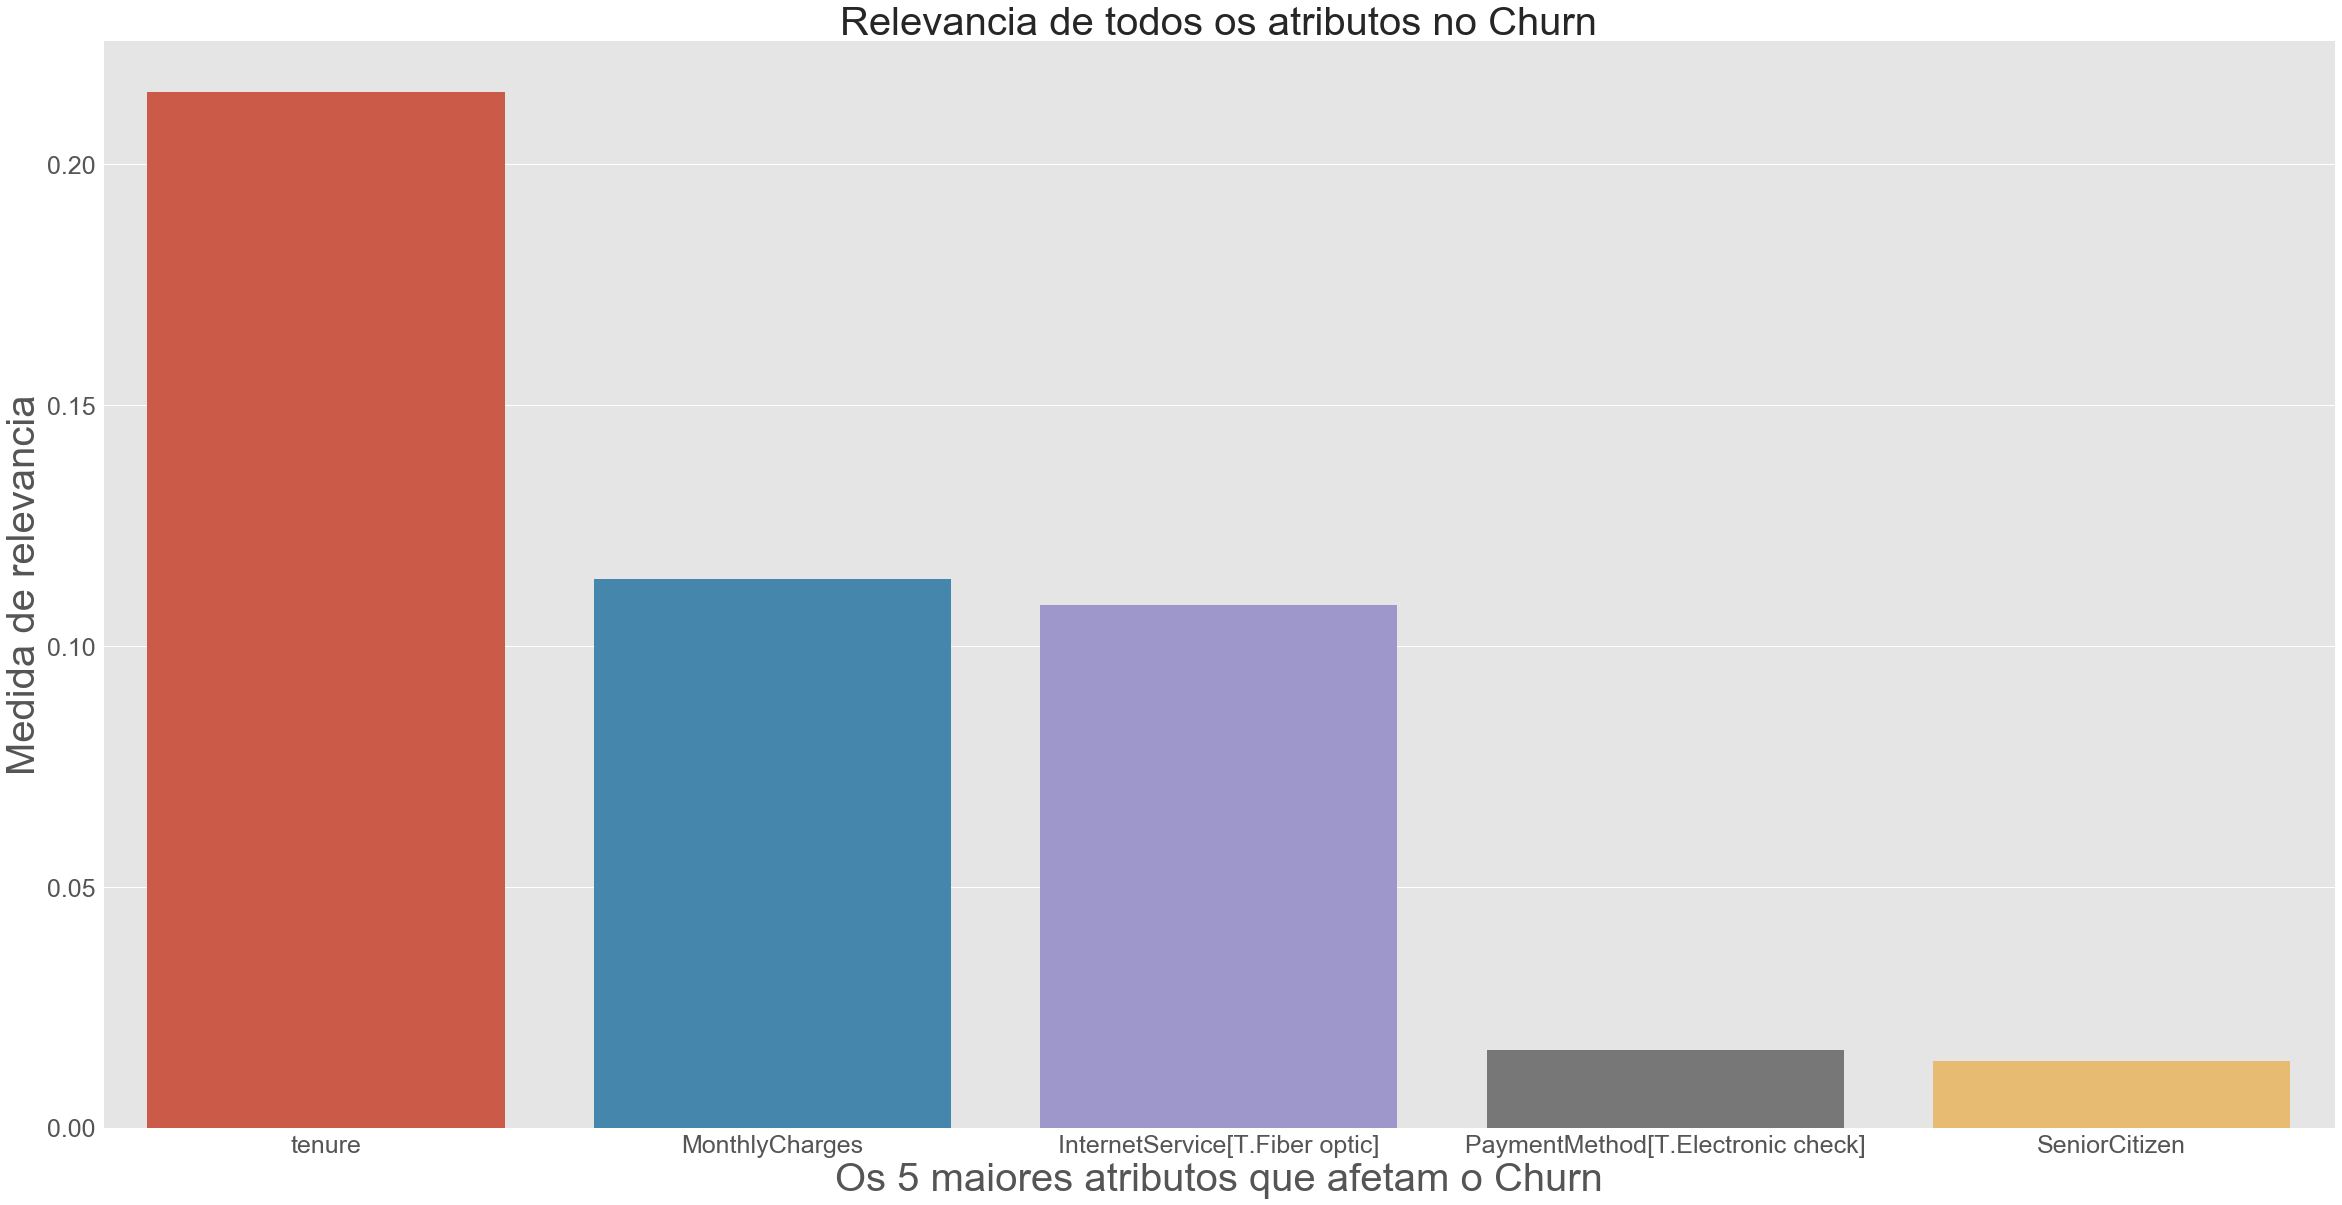

In [10]:
formula = 'Churn ~ tenure + MonthlyCharges + TotalCharges + Contract + PaperlessBilling + PaymentMethod + InternetService + OnlineBackup + OnlineSecurity + DeviceProtection + TechSupport + StreamingTV + StreamingMovies + SeniorCitizen + Partner + Dependents'
y, X = dmatrices(formula, df_churn)

dt = tree.DecisionTreeClassifier(criterion='gini')
dt.fit(X,y)

temp = pd.DataFrame({'relevancia':dt.feature_importances_, 'feature': X.design_info.column_names})\
.sort_values('relevancia', ascending = False, na_position = 'first').head(5)
_ = sns.barplot(x = 'feature', y = 'relevancia', data = temp)
plt.rcParams['figure.figsize']=(40,20)
plt.tick_params(labelsize=25, rotation ='auto')

plt.title('Relevancia de todos os atributos no Churn',size =40)
plt.xlabel('Os 5 maiores atributos que afetam o Churn', size = 40)
_ = plt.ylabel('Medida de relevancia', size = 40)

#### Interpretações / Diagnósticos

Parece que o tempo que a conta está ativa, o valor mensal e o serviço de internet fibra ótica são os principais fatores que afetam o Churn.

Parece que o tempo que a conta está ativa (tenure) é o fator mais importante que contribui para o Churn. Parece que a fidelidade do cliente é muito importante e deve ser estimulada. Quando os clientes estão satisfeitos com o serviço, é provável que eles permaneçam por mais tempo e a probabilidade de eles se movimentarem é menor.

Além disso, há uma distribuição bimodal para churn baseada em cobranças mensais. Os dois modos estão ao redor
US\$ 30 a US\$ 40 e US\$ 70 a US\$ 100. Isso pode refletir uma disparidade de renda entre os clientes. Os métodos de retenção devem refletir os níveis de renda dos clientes. 

Os clientes que têm serviço de Internet parece ser um fator significativo para churn. Aqueles com serviço de fibra ótica tem uma propensao a churn maior do que os clientes que tem o servico DSL, então o serviço pode precisar de melhorias nessa área. Além disso, clientes de fibra óptica devem estar cientes do que podem transferir para DSL. 


Próximos passos:

Para o futuro, pode ser útil coletarmos mais dados demográficos relacionados a renda, estilo de vida e localização. Além disso, poderemos considerar outras features como: consumo de dados e voz, e o número de chamadas para o atendimento ao cliente e número de visitas nas lojas da Telco.

Poderíamos comparar o DT com outros metodos de classificacao como o SVM (Support Vector Machine) e XGBoost.